#Predicting a Player's Position Based on Combine Scores

In this notebook I attempted to predict a player's position based on their NFL Combine scores using classification models. I achieved a top accuracy of 0.588 using CatBoost across 11 positions; this was 608% more accurate than random quessing. I used several different models and consolidated the data in different ways to acheive this result. 

I decided to also do some unsupervised machine learning on this dataset by classifying clustering athletes based on their statistics. I found 3 custers using K-Means that nicely categorized athletes based on the metrics. The results are displayed in a 3D scatter plot. 

Steps Taken:
1. Exploring the data with Pandas and Matplotlib.
2. Attempting several classifiers to see how they perform.
3. Optimizing the models as necessary.
4. Attempting unsupervised ML.

In [115]:
# Import important standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, RocCurveDisplay

In [116]:
combine_raw_df  = pd.read_csv('resources/combine_df.csv')

combine_raw_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
0,1987,Mike Adams,Arizona State,CB,69.8,198.0,28.6,4.42,13.0,32.0,118.0,4.60,NaN
1,1987,John Adickes,Baylor,C,74.8,266.0,33.4,4.97,25.0,26.5,103.0,4.60,NaN
2,1987,Tommy Agee,Auburn,FB,71.8,217.0,29.6,NaN,15.0,NaN,NaN,NaN,NaN
3,1987,David Alexander,Tulsa (OK),C,75.0,279.0,34.9,5.13,22.0,27.5,105.0,4.33,NaN
4,1987,Lyneal Alston,Southern Mississippi,WR,72.1,202.0,27.3,4.64,7.0,32.0,114.0,4.52,NaN


In [117]:
combine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14164 entries, 0 to 14163
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             14164 non-null  int64  
 1   Name             14164 non-null  object 
 2   College          14157 non-null  object 
 3   POS              14164 non-null  object 
 4   Height (in)      14164 non-null  float64
 5   Weight (lbs)     14164 non-null  float64
 6   BMI              14164 non-null  float64
 7   40 Yard          12634 non-null  float64
 8   Bench Press      10276 non-null  float64
 9   Vert Leap (in)   12178 non-null  float64
 10  Broad Jump (in)  12055 non-null  float64
 11  Shuttle          11099 non-null  float64
 12  3Cone            3810 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1.4+ MB


In [118]:
# We'll see how it looks with the raw data 
combine_ml_df = combine_raw_df.copy()

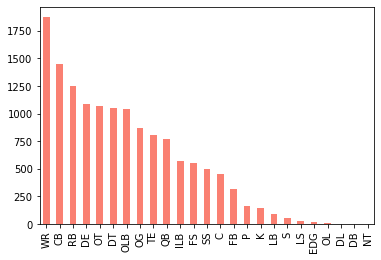

In [119]:
combine_ml_df['POS'].value_counts().plot(kind="bar", color=['salmon']);

<AxesSubplot:ylabel='Frequency'>

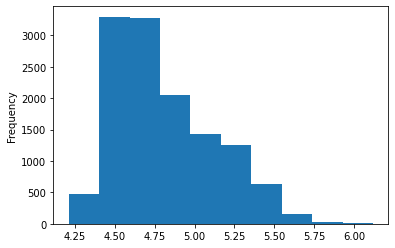

In [120]:
combine_ml_df['40 Yard'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

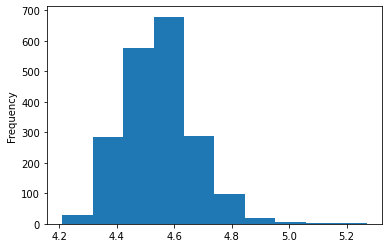

In [121]:
# Checking the histogram of 40 yard times in my personal size range.
my_size_df = combine_ml_df.loc[(combine_ml_df['Height (in)'] >= 69) &
               (combine_raw_df['Height (in)'] <= 73) &
               (combine_raw_df['Weight (lbs)'] <= 198) &
               (combine_raw_df['Weight (lbs)'] <= 205)]

my_size_df['40 Yard'].plot.hist()

In [122]:
# View correlation of the features

combine_ml_df.corr()

,Year,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
Year,1.000000,0.044900,0.069365,0.070116,-0.142552,0.122760,0.176862,0.222967,0.046164,0.080922
Height (in),0.044900,1.000000,0.726128,0.459154,0.609629,0.364746,-0.401206,-0.384149,0.507990,0.496111
Weight (lbs),0.069365,0.726128,1.000000,0.942711,0.832454,0.630859,-0.589704,-0.627841,0.722646,0.765945
BMI,0.070116,0.459154,0.942711,1.000000,0.777052,0.658753,-0.563681,-0.621628,0.683950,0.743201
40 Yard,-0.142552,0.609629,0.832454,0.777052,1.000000,0.421127,-0.748376,-0.775639,0.754312,0.790682
Bench Press,0.122760,0.364746,0.630859,0.658753,0.421127,1.000000,-0.254589,-0.307989,0.352870,0.419582
Vert Leap (in),0.176862,-0.401206,-0.589704,-0.563681,-0.748376,-0.254589,1.000000,0.791132,-0.648387,-0.652518
Broad Jump (in),0.222967,-0.384149,-0.627841,-0.621628,-0.775639,-0.307989,0.791132,1.000000,-0.634616,-0.658839
Shuttle,0.046164,0.507990,0.722646,0.683950,0.754312,0.352870,-0.648387,-0.634616,1.000000,0.804869
3Cone,0.080922,0.496111,0.765945,0.743201,0.790682,0.419582,-0.652518,-0.658839,0.804869,1.000000


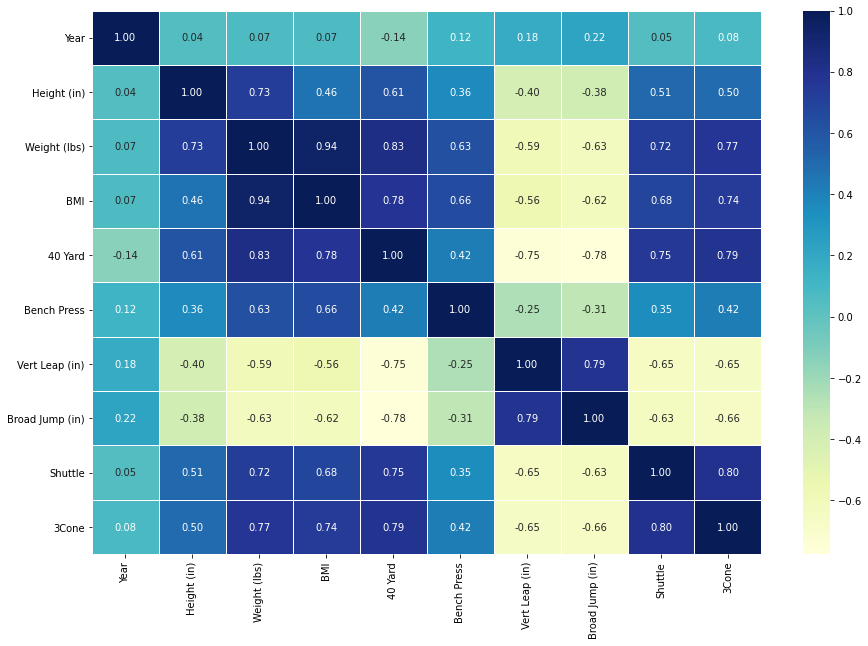

In [123]:
corr_matrix = combine_ml_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap = 'YlGnBu')

<AxesSubplot:xlabel='Feature', ylabel='Correlation'>

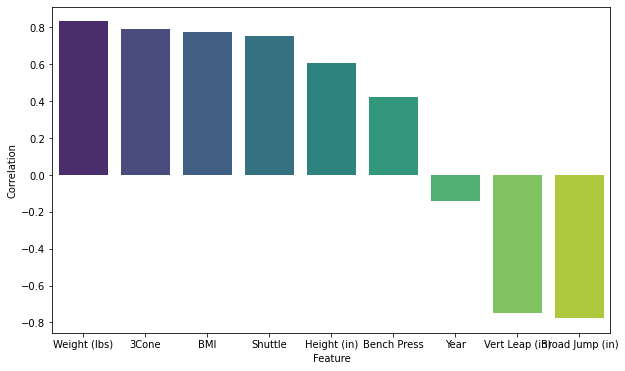

In [124]:
corr_df = combine_ml_df.corr()

# Extract the correlation values for the '40 Yard' column
# Exclude the '40 Yard' itself to avoid a perfect correlation value of 1

corr_40_yard = corr_df['40 Yard'].drop('40 Yard')  

# Convert to a DataFrame for easier plotting
corr_40_yard_df = corr_40_yard.reset_index()
corr_40_yard_df.columns = ['Feature', 'Correlation']

# Sort by correlation values for better visualization
corr_40_yard_df = corr_40_yard_df.sort_values(by='Correlation', ascending=False)

# Create a vertical bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_40_yard_df, x='Feature', y='Correlation', palette='viridis')

<AxesSubplot:xlabel='Feature', ylabel='Correlation'>

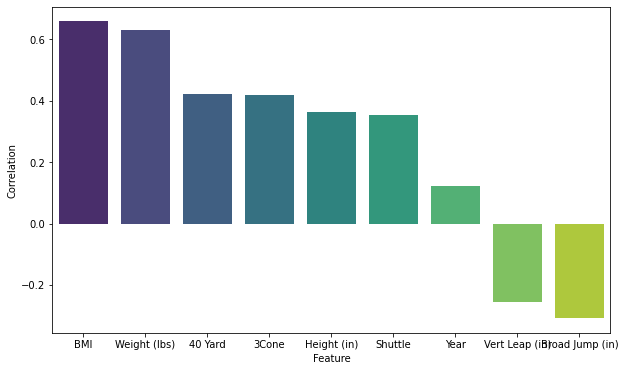

In [125]:
# Extract the correlation values for the 'Bench Press' column
corr_bench = corr_df['Bench Press'].drop('Bench Press')  # Exclude the '40 Yard' itself to avoid a perfect correlation value of 1

# Convert to a DataFrame for easier plotting
corr_bench_df = corr_bench.reset_index()
corr_bench_df.columns = ['Feature', 'Correlation']

# Sort by correlation values for better visualization
corr_bench_df = corr_bench_df.sort_values(by='Correlation', ascending=False)

# Create a vertical bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_bench_df, x='Feature', y='Correlation', palette='viridis')

## Modeling
For this project I want to see if I can determine what position a player will be based of their performance in the NFL combine. I'll use position as the target and the other features determining characteristics.

### We're going to try:
1. K-Nearest Neighbors
2. Random Forest
3. Logistic Regression

In [126]:
# For now we'll drop null values and see how the model does
combine_ml_df.dropna(inplace=True)

# For now we'll drop null values and see how the model does
combine_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3148 entries, 5670 to 14160
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             3148 non-null   int64  
 1   Name             3148 non-null   object 
 2   College          3148 non-null   object 
 3   POS              3148 non-null   object 
 4   Height (in)      3148 non-null   float64
 5   Weight (lbs)     3148 non-null   float64
 6   BMI              3148 non-null   float64
 7   40 Yard          3148 non-null   float64
 8   Bench Press      3148 non-null   float64
 9   Vert Leap (in)   3148 non-null   float64
 10  Broad Jump (in)  3148 non-null   float64
 11  Shuttle          3148 non-null   float64
 12  3Cone            3148 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 344.3+ KB


In [127]:

# Split the data into X and y

X = combine_ml_df.drop(columns=['POS','Name','College'])
y = combine_ml_df['POS']

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [128]:
# Create dicitionary of models for quick access and testing.
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """

    # Set random seed
    np.random.seed(42)

    # Make a dictionary to keep model scores
    model_scores = {}

    # Loop through models
    for name, model in models.items(): 

        # Fit the model to the data
        model.fit(X_train, y_train)

        # Evaluate the model and append its score to model_score
        model_scores[name] = model.score(X_test, y_test)

    return model_scores



In [129]:
models_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
models_scores

c:\Users\seanc\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Logistic Regression': 0.3746031746031746,
 'KNN': 0.4238095238095238,
 'Random Forest': 0.5380952380952381}

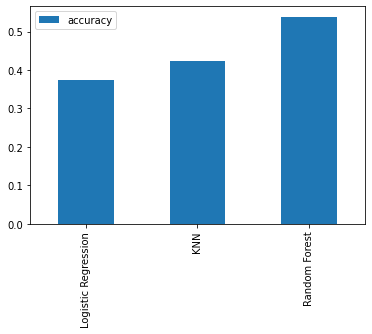

In [130]:
model_compare = pd.DataFrame(models_scores, index=["accuracy"])
model_compare.T.plot.bar();

These results look as toug they can be improved upon. The first steps we can take to improve the model would be to refine the data and then optimize the models.

- We'll start by consolidating or removing positions that have very few occurances.

In [131]:
# Check original dataset
combine_raw_df['POS'].value_counts()

WR     1874
CB     1445
RB     1248
DE     1084
OT     1072
DT     1050
OLB    1037
OG      872
TE      804
QB      769
ILB     572
FS      548
SS      500
C       453
FB      318
P       163
K       145
LB       91
S        53
LS       26
EDG      22
OL       10
DL        4
DB        3
NT        1
Name: POS, dtype: int64

In [132]:
# Check current dataset
combine_ml_df['POS'].value_counts()

WR     379
CB     372
RB     277
DT     263
OLB    263
DE     256
OT     219
OG     209
TE     178
ILB    169
SS     154
FS     153
C      104
FB      80
LB      27
QB      16
LS      11
S        8
EDG      5
OL       3
NT       1
P        1
Name: POS, dtype: int64

One of the biggest differences is the change in the number of QB rows. Clearly QB's don't participate in every event.  

In [133]:
# Get sum of null values for QB positions
combine_raw_df[combine_raw_df['POS'] == 'QB'].isnull().sum()


Year                 0
Name                 0
College              0
POS                  0
Height (in)          0
Weight (lbs)         0
BMI                  0
40 Yard             93
Bench Press        723
Vert Leap (in)     125
Broad Jump (in)    123
Shuttle            154
3Cone              651
dtype: int64

From this data it would appear that most QBs opt out of the bench press and 3 cone events. In this case we have a few options, like replacing the null values for the bench press with the average value for the QBs that did participate, but assuming future QBs could continue to opt out, it may not be the best option for prediction. In this case we'll drop the bench press and 3 cone events.

In [134]:
# Drop the columns and NaN values

combine_ml_df = combine_raw_df.drop(columns=['Bench Press', '3Cone'])

combine_ml_df.dropna(inplace=True)

combine_ml_df = combine_ml_df[~combine_ml_df['POS'].isin(['P', 'S', 'K', 'DL', 'LS', 'EDG', 'OL', 'DL', 'DB', 'NT'])]

# Check current dataset

combine_ml_df['POS'].value_counts()


WR     1462
CB     1106
RB      887
OT      858
DE      835
OLB     811
DT      808
OG      706
TE      655
QB      587
ILB     445
FS      433
SS      380
C       361
FB      252
LB       57
Name: POS, dtype: int64

We may also want to combine some positions. Although there are some diffrences between ILB and OLB for example, they are similar.

In [135]:
combine_raw_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
0,1987,Mike Adams,Arizona State,CB,69.8,198.0,28.6,4.42,13.0,32.0,118.0,4.60,NaN
1,1987,John Adickes,Baylor,C,74.8,266.0,33.4,4.97,25.0,26.5,103.0,4.60,NaN
2,1987,Tommy Agee,Auburn,FB,71.8,217.0,29.6,NaN,15.0,NaN,NaN,NaN,NaN
3,1987,David Alexander,Tulsa (OK),C,75.0,279.0,34.9,5.13,22.0,27.5,105.0,4.33,NaN
4,1987,Lyneal Alston,Southern Mississippi,WR,72.1,202.0,27.3,4.64,7.0,32.0,114.0,4.52,NaN


In [136]:
# Replace some niche postions with a more generalized version.
combine_ml_df['POS'].replace('FB', 'RB', inplace=True)
combine_ml_df['POS'].replace('SS', 'S', inplace=True)
combine_ml_df['POS'].replace('FS', 'S', inplace=True)
combine_ml_df['POS'].replace('FB', 'RB', inplace=True)
combine_ml_df['POS'].replace('ILB', 'LB', inplace=True)
combine_ml_df['POS'].replace('OLB', 'LB', inplace=True)

combine_ml_df['POS'].value_counts()


WR    1462
LB    1313
RB    1139
CB    1106
OT     858
DE     835
S      813
DT     808
OG     706
TE     655
QB     587
C      361
Name: POS, dtype: int64

In [137]:
combine_ml_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Vert Leap (in),Broad Jump (in),Shuttle
0,1987,Mike Adams,Arizona State,CB,69.8,198.0,28.6,4.42,32.0,118.0,4.60
1,1987,John Adickes,Baylor,C,74.8,266.0,33.4,4.97,26.5,103.0,4.60
3,1987,David Alexander,Tulsa (OK),C,75.0,279.0,34.9,5.13,27.5,105.0,4.33
4,1987,Lyneal Alston,Southern Mississippi,WR,72.1,202.0,27.3,4.64,32.0,114.0,4.52
5,1987,Steve Alvord,Washington,DE,76.5,273.0,32.8,4.86,28.5,108.0,4.49


## Tune Models

Now that we've changeed the data, we'll attempt to optimize the models that see if our results improve at all. 

In [138]:
# Split the data into X and y again

X = combine_ml_df.drop(columns=['POS','Name','College'])
y = combine_ml_df['POS']

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

models_scores = fit_and_score(models, X_train, X_test, y_train, y_test)

model_compare = pd.DataFrame(models_scores, index=["accuracy"])
model_compare

c:\Users\seanc\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Logistic Regression,KNN,Random Forest
accuracy,0.468765,0.495068,0.585721


In [139]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(X_train,y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

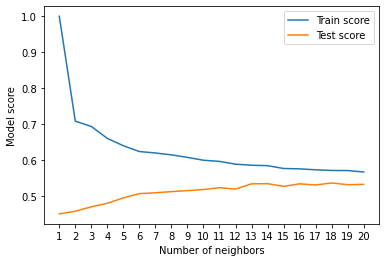

In [140]:
# Plot the results

plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

It looks like 18 neighbors was the highest scoring, let's check the accuracy.

In [170]:
# Try our model with 18
knn.set_params(n_neighbors=18)
    
# Fit the algorithm
knn.fit(X_train,y_train)

# Update the training scores list
knn.score(X_test,y_test)


0.5364020666979803

Our best model with KNN achieved an accuracy of 0.536, we'll tune the Logistic Regression and Random Forest models next.

## Hyperparam tuning with RandomizedSearchCV

We're going to tune these models using RandomizedSearchCV:
* Logsitic Regression
* Random Forest

In [141]:
# Create a hyperparam for Logistic Regression
log_reg_grid = {"C" : np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Createt a hyperparam grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [142]:
# Tune LogisiticRegression

np.random.seed(42)

# Setup random hyperparams search for Logistic Regression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparam search model f  or LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [143]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 1438.44988828766}

In [144]:
rs_log_reg.score(X_test, y_test)

0.5011742602160639

In [145]:
np.random.seed(42)

#Set up hyperparams for RFC
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparam search model for randomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [146]:
# Find best hyperparameters
rs_rf.best_params_

{'n_estimators': 910,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [147]:
# Evaluate the randomized search cv
rs_rf.score(X_test, y_test)

0.5871301080319399

Some improvements were made, but we may still be able to do better.

### Let's try with XGBoost

In [148]:
# Encode the classification values
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

In [149]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train_le)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [150]:
xgb_model.score(X_test,y_test_le)

0.5645843118835134

In [151]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = xgb_model.predict(X_test)
#y_pred = le.inverse_transform(y_pred)

accuracy_score(y_test_le, y_pred)

0.5645843118835134

In [152]:
len(y_train.unique())

12

In [153]:
val_list = np.unique(y_train_le)
print(val_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [154]:
val_list = np.unique(y_pred)
print(val_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [155]:
# Create a grid to try and tune XGBoost
xgb_grid = {"max_depth": [None, 3, 5, 10],
            "subsample": np.arange(0.1,1,0.1),
           "colsample_bylevel": np.arange(0.1,1,0.1),
           "colsample_bytree": np.arange(0.1,1,0.1),
           "min_child_weight": [1, 5, 25, 50, 100],
           "n_estimators": [10,50,100,250,500,1000],
           "learning_rate": np.arange(0.01,0.2,0.01)
           }

In [156]:
#Set up hyperparams for RFC
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                           param_distributions=xgb_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)


In [157]:
# Fit random hyperparam search model for randomForestClassifier()
rs_xgb.fit(X_train, y_train_le)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'colsample_bytree': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                        

In [158]:
# Find best hyperparameters
rs_xgb.best_params_

{'subsample': 0.7000000000000001,
 'n_estimators': 250,
 'min_child_weight': 100,
 'max_depth': 5,
 'learning_rate': 0.12,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 0.5}

In [159]:
# Evaluate the randomized search cv
rs_xgb.score(X_test, y_test_le)

0.5749178017848755

XGBoost, even when tuned, did not perform as well as our tuned Random Forest Model.

## Let's try with CatBoost

In [160]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(random_seed=42)

cb_model.fit(X_train,y_train)

cb_model.score(X_test,y_test)

Learning rate set to 0.088259
0:	learn: 2.2603588	total: 54.7ms	remaining: 54.6s
1:	learn: 2.0875246	total: 107ms	remaining: 53.5s
2:	learn: 1.9673419	total: 156ms	remaining: 51.8s
3:	learn: 1.8659444	total: 203ms	remaining: 50.4s
4:	learn: 1.7792497	total: 256ms	remaining: 50.9s
5:	learn: 1.7028956	total: 307ms	remaining: 50.9s
6:	learn: 1.6387240	total: 362ms	remaining: 51.3s
7:	learn: 1.5869699	total: 415ms	remaining: 51.5s
8:	learn: 1.5380293	total: 468ms	remaining: 51.5s
9:	learn: 1.4939642	total: 516ms	remaining: 51s
10:	learn: 1.4575057	total: 562ms	remaining: 50.5s
11:	learn: 1.4253889	total: 609ms	remaining: 50.2s
12:	learn: 1.3966821	total: 658ms	remaining: 49.9s
13:	learn: 1.3694039	total: 707ms	remaining: 49.8s
14:	learn: 1.3442910	total: 757ms	remaining: 49.7s
15:	learn: 1.3225760	total: 807ms	remaining: 49.7s
16:	learn: 1.3034088	total: 866ms	remaining: 50.1s
17:	learn: 1.2864066	total: 919ms	remaining: 50.1s
18:	learn: 1.2685403	total: 970ms	remaining: 50.1s
19:	learn: 1

0.5843118835133866

In [162]:
# Attempt to optimize the CatBoost model
cb_grid = {'depth': [2,4,6,8,10],
              'learning_rate': [0.01, 0.025, 0.05, 0.10, 0.50],
              'iterations':   [200, 150, 100]}

#Set up hyperparams for RFC
rs_cb = RandomizedSearchCV(CatBoostClassifier(random_seed=42),
                           param_distributions=cb_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

rs_cb.fit(X_train, y_train)

rs_cb.score(X_test,y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 1.9081885	total: 5.18ms	remaining: 772ms
1:	learn: 1.6486987	total: 9.7ms	remaining: 718ms
2:	learn: 1.5218711	total: 15ms	remaining: 737ms
3:	learn: 1.4394480	total: 21ms	remaining: 767ms
4:	learn: 1.3684196	total: 27.5ms	remaining: 797ms
5:	learn: 1.3187818	total: 34.4ms	remaining: 826ms
6:	learn: 1.2897794	total: 42ms	remaining: 858ms
7:	learn: 1.2640633	total: 48.8ms	remaining: 866ms
8:	learn: 1.2490012	total: 55.2ms	remaining: 864ms
9:	learn: 1.2227821	total: 63.4ms	remaining: 888ms
10:	learn: 1.2038764	total: 70.7ms	remaining: 893ms
11:	learn: 1.1939813	total: 77.8ms	remaining: 895ms
12:	learn: 1.1818960	total: 85.2ms	remaining: 897ms
13:	learn: 1.1789633	total: 91.9ms	remaining: 893ms
14:	learn: 1.1583366	total: 99.7ms	remaining: 897ms
15:	learn: 1.1508860	total: 106ms	remaining: 886ms
16:	learn: 1.1350396	total: 114ms	remaining: 890ms
17:	learn: 1.1255029	total: 121ms	remaining: 887ms
18:	learn: 1.1233337	t

0.5955847815875999

In [63]:
rs_cb.best_params_

{'learning_rate': 0.05, 'iterations': 150, 'depth': 10}

To compare our models, lets compare to randomly guessing positions.

In [58]:
# Using the encoded positions

num_pos = len(np.unique(y_test_le))

# Generate random predictions
y_pred_random = np.random.choice(num_pos, size=len(y_test_le))

# Calculate accuracy
accuracy_score(y_test_le, y_pred_random)

0.08266791921089714

The tuned Random Forest and CatBoost models both produced an accuracy of 0.596; much better than random guessing where we saw an accuracy of 0.083. Those odds might provide an advantage for gambling, but if an athlete wanted insights into what position might suite them best then they would still be left with an undesirable degree of uncertainty. Another approach might be to see a range of positions that fit them. Clustering can help with this.

# KMeans for Player Statistics

Here we will:
1. Import the KMeans algorithm.
2. Group Players into clusters.
3. Summarize the cluster results.
4. Visualize the results.
5. Use our categorization algorithms again to predict player classifications.

In [47]:
# View the data again
combine_df = combine_raw_df
combine_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
0,1987,Mike Adams,Arizona State,CB,69.8,198.0,28.6,4.42,13.0,32.0,118.0,4.60,NaN
1,1987,John Adickes,Baylor,C,74.8,266.0,33.4,4.97,25.0,26.5,103.0,4.60,NaN
2,1987,Tommy Agee,Auburn,FB,71.8,217.0,29.6,NaN,15.0,NaN,NaN,NaN,NaN
3,1987,David Alexander,Tulsa (OK),C,75.0,279.0,34.9,5.13,22.0,27.5,105.0,4.33,NaN
4,1987,Lyneal Alston,Southern Mississippi,WR,72.1,202.0,27.3,4.64,7.0,32.0,114.0,4.52,NaN


In [48]:
combine_df.isna().sum()

Year                   0
Name                   0
College                7
POS                    0
Height (in)            0
Weight (lbs)           0
BMI                    0
40 Yard             1530
Bench Press         3888
Vert Leap (in)      1986
Broad Jump (in)     2109
Shuttle             3065
3Cone              10354
dtype: int64

We need to get rid of the NaN values again. In this case we will eliminate NaN values, but only delete the 3Cone column. We won't be as worried about positions such as QB, where bench press data is missing. We'll be more focused on how the algorithm classifies players based on as many statistics as possible. The 3 cone event seems to have been included much later than the others and thus has less rows of data so will be excluded. 

In [49]:
# Drop 3Cone and NaN Values
combine_df= combine_df.drop(columns=['3Cone', 'Bench Press'])
combine_df = combine_df.dropna()

combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10734 entries, 0 to 14160
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             10734 non-null  int64  
 1   Name             10734 non-null  object 
 2   College          10734 non-null  object 
 3   POS              10734 non-null  object 
 4   Height (in)      10734 non-null  float64
 5   Weight (lbs)     10734 non-null  float64
 6   BMI              10734 non-null  float64
 7   40 Yard          10734 non-null  float64
 8   Vert Leap (in)   10734 non-null  float64
 9   Broad Jump (in)  10734 non-null  float64
 10  Shuttle          10734 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1006.3+ KB


In [50]:
combine_df.isna().sum()

Year               0
Name               0
College            0
POS                0
Height (in)        0
Weight (lbs)       0
BMI                0
40 Yard            0
Vert Leap (in)     0
Broad Jump (in)    0
Shuttle            0
dtype: int64

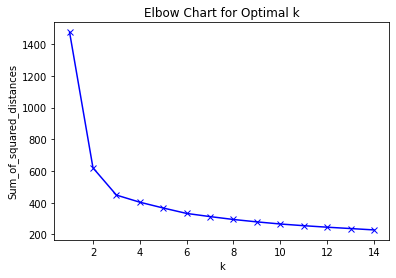

In [51]:
# Import KMeans algorithm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Store categorical data seperately
combine_categorical = combine_df.drop(columns=combine_df.columns[4:])

# Get just values
stats_df = combine_df.drop(columns=combine_df.columns[:4])

# Scale stats
scaler = MinMaxScaler()

scaler.fit(stats_df)
scaled_stats_df = scaler.transform(stats_df)

# Test different values for k
sum_of_squared_distances = []

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_stats_df)
    sum_of_squared_distances.append(km.inertia_)

# Plot the elbow chart
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Chart for Optimal k')
plt.show()

#### The elbow appears at 3 clusters, so that's what we'll try. Next we'll run the model and combine the predicted clusters with the original dataset.

In [52]:
# Fit the model with just the desired clusters
km = KMeans(n_clusters=3)
km.fit(scaled_stats_df)

# Create resulting clusters
predicted = km.predict(scaled_stats_df)

# Add predictions to the orignial dataframe (unscaled and with all columns)
combine_df['Clusters'] = predicted

combine_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Vert Leap (in),Broad Jump (in),Shuttle,Clusters
0,1987,Mike Adams,Arizona State,CB,69.8,198.0,28.6,4.42,32.0,118.0,4.60,1
1,1987,John Adickes,Baylor,C,74.8,266.0,33.4,4.97,26.5,103.0,4.60,2
3,1987,David Alexander,Tulsa (OK),C,75.0,279.0,34.9,5.13,27.5,105.0,4.33,0
4,1987,Lyneal Alston,Southern Mississippi,WR,72.1,202.0,27.3,4.64,32.0,114.0,4.52,1
5,1987,Steve Alvord,Washington,DE,76.5,273.0,32.8,4.86,28.5,108.0,4.49,2


In [53]:
# Describe each of the clusters, what makes them unique?
cluster_info = combine_df.groupby('Clusters').describe()

cluster_info = pd.DataFrame(cluster_info)

cluster_info.drop(columns=['Year'],inplace=True)

for column in cluster_info.columns:
    measure_df = pd.DataFrame(cluster_info[column])
    print(measure_df)



         Height (in)
               count
Clusters            
0             2781.0
1             4421.0
2             3532.0
         Height (in)
                mean
Clusters            
0          76.061546
1          71.654924
2          74.733332
         Height (in)
                 std
Clusters            
0           1.662157
1           2.003635
2           1.876679
         Height (in)
                 min
Clusters            
0               70.9
1               61.5
2               67.5
         Height (in)
                 25%
Clusters            
0              74.90
1              70.25
2              73.50
         Height (in)
                 50%
Clusters            
0              76.00
1              71.63
2              74.80
         Height (in)
                 75%
Clusters            
0              77.13
1              73.00
2              76.00
         Height (in)
                 max
Clusters            
0              82.40
1              78.30
2            

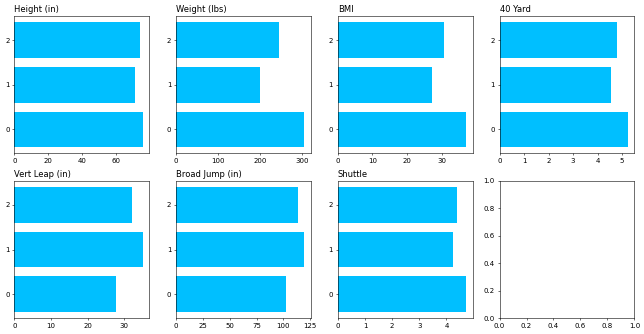

In [172]:
# Combine averages dataframe
combine_means = combine_df.groupby('Clusters').mean().reset_index()

# Create a figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=50)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Multiple line plots
for num, column in enumerate(combine_means.drop(['Clusters','Year'], axis=1), start=1):
    ax = axes[num-1]

    # Plot the line plot
    ax.barh(combine_means['Clusters'].astype('string'), combine_means[column], color='deepskyblue', label=column)

    # Add title
    ax.set_title(column, loc='left', fontsize=12, fontweight=0, color='black')

# Show the graph
plt.show()

In [55]:
combine_df.pivot_table(index=['POS'],columns=['Clusters'],
                       aggfunc={'Clusters': 'count'}, fill_value=0)

Clusters           
Clusters        0     1    2
POS                         
C             350     0   11
CB              0  1101    5
DB              0     3    0
DE            130     1  704
DL              0     0    3
DT            728     0   80
EDG             0     0   17
FB              4    33  215
FS              0   419   14
ILB             2    37  406
K               0     3    4
LB              0    10   47
LS              0     0   17
NT              1     0    0
OG            696     0   10
OL              6     0    0
OLB             3   139  669
OT            838     2   18
P               0     4    4
QB              1   120  466
RB              0   756  131
S               0    28    1
SS              0   365   15
TE             22    17  616
WR              0  1383   79

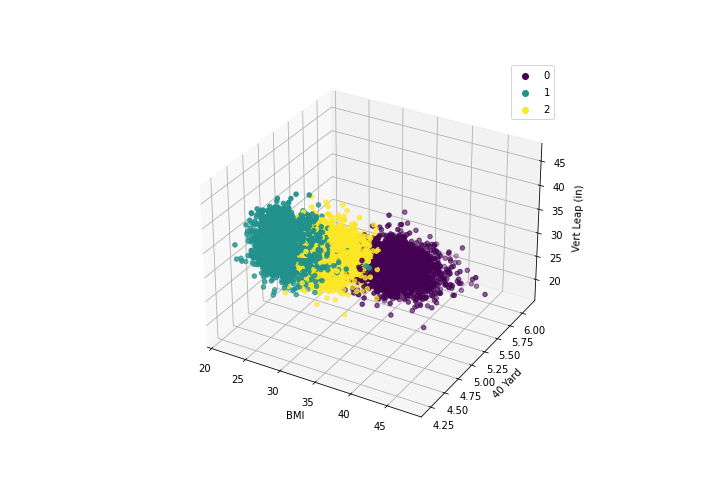

In [56]:
# Create an interactive 3d Scatter plot of the different features

from mpl_toolkits.mplot3d import Axes3D

# for creating a responsive plot 
%matplotlib widget 
  
# Select features for the plot
xs = combine_df['BMI']
# ys = combine_df['Bench Press']
ys = combine_df['40 Yard']
zs = combine_df['Vert Leap (in)']


fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(xs, ys, zs, c=combine_df['Clusters'])

ax.set_xlabel('BMI') 
# ax.set_ylabel('Bench Press') 
ax.set_ylabel('40 Yard')
ax.set_zlabel('Vert Leap (in)') 

ax.legend(*scatter.legend_elements())

plt.show()

### Conclusions
Although we weren't very close in predicting positions based on combine scores, we did find a way to categorize players in a meaningful way using unsupervised machine learning. The clusters are displayed beautifly in the 3D scatter plot above, in an almost "kabob" like configuration. We also found that most positions lean toward a certain cluster, although some postions like Corner Back and Wide Reciever lean toward the same clusters which might be part of what makes positon predictions difficult. 

In the end, the Combine events may show certain aspects of speed, agility, or strength, but they are not all encompassing when it comes to which position a player will take. 